In [1]:
# !pip install swifter
# !pip install kagglehub
# !pip install underthesea
# !pip install tabulate
# !pip install googletrans==4.0.0-rc1
# !pip install wordcloud

NLTK Parser: [Underthesea](https://underthesea.readthedocs.io/en/latest/readme.html)

Corpus Dataset: [KaggleHub - Pham Tuyet](https://www.kaggle.com/datasets/phamtuyet/text-classification?select=text_tokenizer.xlsx)

Stopword Dataset: [KaggleHub - L3VIEVIL](https://www.kaggle.com/datasets/linhlpv/vietnamese-stopwords)



In [2]:
# --- Core Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings

# --- NLP & Utilities ---
from datasets import load_dataset
import kagglehub
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from googletrans import Translator
from tqdm.auto import tqdm

# --- Setup ---
warnings.simplefilter("ignore") # Ignore warnings for cleaner output
tqdm.pandas(desc="Processing") # Initialize tqdm for pandas

# Define folder for saving results
PKL_FOLDER = 'pkl_folder'
if not os.path.exists(PKL_FOLDER):
    os.makedirs(PKL_FOLDER)
    print(f"Created directory: {PKL_FOLDER}")

# Use Google Translator
try:
    translator = Translator()
    print("Google Translator initialized.")
except Exception as e:
    print(f"Could not initialize translator: {e}")
    translator = None



Google Translator initialized.


In [ ]:
# Define the English mapping before loading the data
LABEL_MAPPING = {
    'chinh-tri': 'Politics',
    'doi-song': 'Daily_Life',
    'giao-duc': 'Education',
    'kinh-doanh': 'Business',
    'phap-luat': 'Law',
    'suc-khoe': 'Health',
    'the-gioi': 'World',
    'the-thao': 'Sports'
}


# Load Dataset
try:
    # Use kagglehub to download if not already done
    news_dataset_path = kagglehub.dataset_download('phamtuyet/text-classification')
    print("News dataset downloaded/located via kagglehub.")
except Exception as e:
    print(f"Error downloading/finding news dataset via kagglehub: {e}")
    
    news_dataset_path = None # Set to None if download fails

# Load the News dataset
if news_dataset_path and os.path.exists(os.path.join(news_dataset_path, 'text.xlsx')):
    print("Loading full news dataset...")
    # Load the excel file 
    full_news_df = pd.read_excel(
        os.path.join(news_dataset_path, 'text.xlsx'),
        header=None,
        names=['content', 'label'] # Assign column names
    )
    print("Full news dataset loaded.")

    # Remove the header row that was loaded as data
    full_news_df = full_news_df[full_news_df['label'] != 'label'].copy()

    # Create a Balanced Subset (since the dataset is quite large)
    N_SAMPLES_PER_CATEGORY = 2000 

    # Group by category, take N samples, and recombine
    vn_df_news_subset = full_news_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), N_SAMPLES_PER_CATEGORY), random_state=42)
    )

    print("Subset created.")
    vn_df = vn_df_news_subset.reset_index(drop=True)

    # Apply English label mapping 
    vn_df['label'] = vn_df['label'].map(LABEL_MAPPING)

    print("\nNew DataFrame (vn_df) Info:")
    vn_df.info()
    print("\nCategory distribution in the subset (English Labels):")
    print(vn_df['label'].value_counts())

else:
    print("Error: Could not load the news dataset file. Please check the path.")

News dataset downloaded/located via kagglehub.
Loading full news dataset...
Full news dataset loaded.
Subset created.

New DataFrame (vn_df) Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  16000 non-null  object
 1   label    16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

Category distribution in the subset (English Labels):
label
Politics      2000
Daily_Life    2000
Education     2000
Business      2000
Law           2000
Health        2000
World         2000
Sports        2000
Name: count, dtype: int64


In [4]:
# Load Stopword
print("Loading Vietnamese stopwords...")
stopword_path = kagglehub.dataset_download("linhlpv/vietnamese-stopwords")
stopword_df = pd.read_csv(f'{stopword_path}/vietnamese-stopwords.txt', header=None, names=['word'])
vietnamese_stopwords_set = set(stopword_df['word'].tolist())
print(f"Loaded {len(vietnamese_stopwords_set)} stopwords into a set.")

Loading Vietnamese stopwords...
Loaded 1942 stopwords into a set.


# Question 1: Estimates Stopword Proportion

Cache not found for Task 1. Running analysis...
Tokenizing sentences for Task 1...


Processing:   0%|          | 0/16000 [00:00<?, ?it/s]

Task 1 analysis complete. Saving results to pkl_folder\task1.pkl...
Task 1 results saved.

--- Stopword Proportion by Category ---
| Category   |   total_tokens |   stopword_tokens |   Stopword Proportion (%) |
|:-----------|---------------:|------------------:|--------------------------:|
| Business   |        1374220 |            566917 |                     41.25 |
| Daily_Life |        1341068 |            665480 |                     49.62 |
| Education  |        1091187 |            506557 |                     46.42 |
| Health     |        1111659 |            452414 |                     40.70 |
| Law        |         887971 |            332441 |                     37.44 |
| Politics   |        1272301 |            475945 |                     37.41 |
| Sports     |         690365 |            269146 |                     38.99 |
| World      |         816505 |            370275 |                     45.35 |


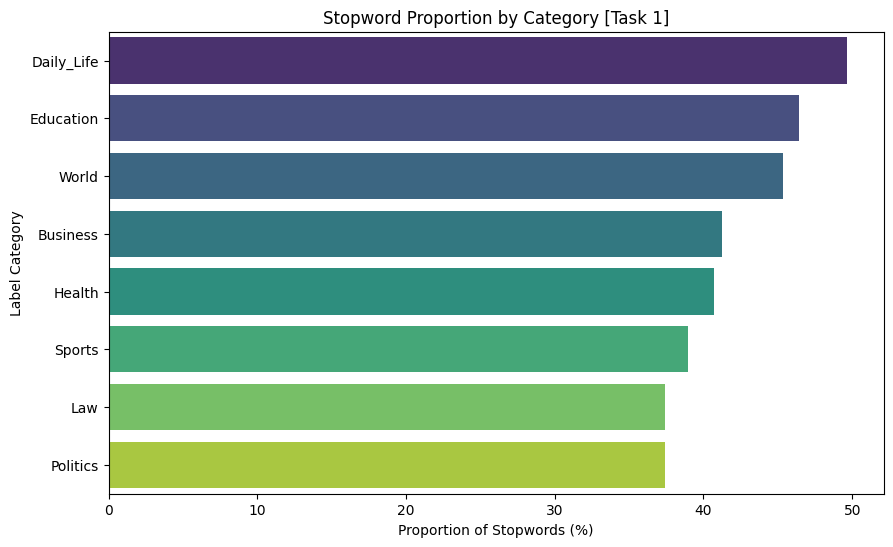

In [5]:
TASK1_STATS_PKL = os.path.join(PKL_FOLDER, 'task1.pkl') 

# Check if cached file exists
if os.path.exists(TASK1_STATS_PKL):
    print(f"Loading cached Task 1 results from {TASK1_STATS_PKL}...")
    with open(TASK1_STATS_PKL, 'rb') as f:
        stats_df_task1 = pickle.load(f) # Use final variable name
    print("Task 1 results loaded.")

else:
    print(f"Cache not found for Task 1. Running analysis...")

    # Define function to count tokens and stopwords
    def process_text_task1(text):
        tokens = word_tokenize(str(text).lower())
        stopword_count = sum(1 for token in tokens if token in vietnamese_stopwords_set)
        return pd.Series({'total_tokens': len(tokens), 'stopword_tokens': stopword_count})

    # Apply function with progress bar
    print("Tokenizing sentences for Task 1...")
    token_counts_df = vn_df['content'].progress_apply(process_text_task1)

    # Combine counts with news labels
    CATEGORY_COLUMN = 'label'
    results_df = pd.concat([vn_df[CATEGORY_COLUMN], token_counts_df], axis=1)

    # Aggregate by category
    stats_df_task1 = results_df.groupby(CATEGORY_COLUMN).sum() # Use final variable name

    # Calculate proportion
    stats_df_task1['Stopword Proportion (%)'] = (stats_df_task1['stopword_tokens'] / stats_df_task1['total_tokens']) * 100

    # Reset index and keep category names
    stats_df_task1 = stats_df_task1.reset_index().rename(columns={CATEGORY_COLUMN: 'Category'})

    # Save results
    print(f"Task 1 analysis complete. Saving results to {TASK1_STATS_PKL}...")
    with open(TASK1_STATS_PKL, 'wb') as f:
        pickle.dump(stats_df_task1, f)
    print("Task 1 results saved.")

# --- Display Task 1 Results ---

# Table
print("\n--- Stopword Proportion by Category ---")
print(stats_df_task1[['Category', 'total_tokens', 'stopword_tokens', 'Stopword Proportion (%)']].to_markdown(index=False, floatfmt=".2f"))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Stopword Proportion (%)',
    y='Category',
    data=stats_df_task1.sort_values('Stopword Proportion (%)', ascending=False),
    palette='viridis'
)
plt.title('Stopword Proportion by Category [Task 1]') # Updated title
plt.xlabel('Proportion of Stopwords (%)')
plt.ylabel('Label Category')

plt.savefig('plot/task1.png', dpi=300, bbox_inches='tight')
plt.show()

# Question 2: TF-IDF Statistics for Stopwords

In [6]:
# Define filename for caching
TASK2_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task2.pkl')

# Check if cached results exist
if os.path.exists(TASK2_TFIDF_PKL):
    print(f"Loading cached Task 2 results from {TASK2_TFIDF_PKL}...")
    with open(TASK2_TFIDF_PKL, 'rb') as f:
        tfidf_stats_df = pickle.load(f)
    print("Results loaded.")

else:
    print(f"Cache not found for Task 2. Running analysis...")

    # Ensure stopwords set is loaded
    if 'vietnamese_stopwords_set' not in locals():
         vietnamese_stopwords_set = set(stopword_df['word'].tolist())

    # Prepare data structures
    categories = vn_df['label'].unique() 
    stopword_tfidf_scores = {word: [] for word in vietnamese_stopwords_set}

    # Define tokenizer
    def vn_tokenizer(text):
        return word_tokenize(str(text).lower())

    # Calculate TF-IDF per category
    print("Calculating TF-IDF for each category...")
    # Wrap categories with tqdm for the main progress bar
    for category in tqdm(categories, desc="Processing Categories for TF-IDF"):
        print(f"  Starting TF-IDF calculation for category: '{category}'...") 
        
        category_texts = vn_df[vn_df['label'] == category]['content'].tolist()
        tfidf_vectorizer = TfidfVectorizer(tokenizer=vn_tokenizer, stop_words=None)

        try:
            # This is the potentially slow step for each category
            tfidf_matrix = tfidf_vectorizer.fit_transform(category_texts)
            feature_names = tfidf_vectorizer.get_feature_names_out()
            vocab_index = {word: idx for idx, word in enumerate(feature_names)}

            # Get average TF-IDF for stopwords in this category
            # This inner loop is usually fast
            for stopword in vietnamese_stopwords_set:
                if stopword in vocab_index:
                    stopword_idx = vocab_index[stopword]
                    avg_score = np.mean(tfidf_matrix[:, stopword_idx].toarray())
                    stopword_tfidf_scores[stopword].append(avg_score)
                else:
                    stopword_tfidf_scores[stopword].append(0.0)

        except ValueError as e: # Handle empty categories
            print(f"  Skipping category '{category}' due to error: {e}")
            for stopword in vietnamese_stopwords_set:
                 stopword_tfidf_scores[stopword].append(0.0)
        
        # --- Add a print statement to show when a category finishes ---
        print(f"  Finished TF-IDF calculation for category: '{category}'.") 


    # Calculate statistics across categories
    print("\nCalculating TF-IDF statistics...")
    tfidf_stats = []
    # This loop is generally fast
    for stopword, scores in stopword_tfidf_scores.items(): 
        if scores:
            tfidf_stats.append({
                'Stopword': stopword, 'Average TF-IDF': np.mean(scores), 'Std Dev TF-IDF': np.std(scores),
                'Max TF-IDF': np.max(scores), 'Min TF-IDF': np.min(scores)
            })
        else:
             tfidf_stats.append({ 'Stopword': stopword, 'Average TF-IDF': 0.0, 'Std Dev TF-IDF': 0.0, 
                                  'Max TF-IDF': 0.0, 'Min TF-IDF': 0.0 })

    # Convert stats list to DataFrame
    tfidf_stats_df = pd.DataFrame(tfidf_stats)

    # Save results
    print(f"Analysis complete. Saving results to {TASK2_TFIDF_PKL}...")
    with open(TASK2_TFIDF_PKL, 'wb') as f:
        pickle.dump(tfidf_stats_df, f)
    print("Task 2 results saved.")



Cache not found for Task 2. Running analysis...
Calculating TF-IDF for each category...


Processing Categories for TF-IDF:   0%|          | 0/8 [00:00<?, ?it/s]

  Starting TF-IDF calculation for category: 'Politics'...
  Finished TF-IDF calculation for category: 'Politics'.
  Starting TF-IDF calculation for category: 'Daily_Life'...
  Finished TF-IDF calculation for category: 'Daily_Life'.
  Starting TF-IDF calculation for category: 'Education'...
  Finished TF-IDF calculation for category: 'Education'.
  Starting TF-IDF calculation for category: 'Business'...
  Finished TF-IDF calculation for category: 'Business'.
  Starting TF-IDF calculation for category: 'Law'...
  Finished TF-IDF calculation for category: 'Law'.
  Starting TF-IDF calculation for category: 'Health'...
  Finished TF-IDF calculation for category: 'Health'.
  Starting TF-IDF calculation for category: 'World'...
  Finished TF-IDF calculation for category: 'World'.
  Starting TF-IDF calculation for category: 'Sports'...
  Finished TF-IDF calculation for category: 'Sports'.

Calculating TF-IDF statistics...
Analysis complete. Saving results to pkl_folder\task2.pkl...
Task 2 resu

In [7]:
# Display Task 2 Results 
tfidf_stats_df_sorted = tfidf_stats_df.sort_values('Average TF-IDF')

# Get lowest 15 (including zeros) and highest 15 overall
lowest_15_df = tfidf_stats_df_sorted.head(15).copy()
highest_15_df = tfidf_stats_df_sorted.tail(15).copy() 

# Translate if translator is available
if translator:
    print("\nTranslating top/bottom stopwords...")
    def translate_words(words_list): # Assumes function exists
        translations = []
        for word in words_list:
            try:
                translated = translator.translate(word, src='vi', dest='en')
                translations.append(translated.text if hasattr(translated, 'text') else word)
            except Exception as e:
                translations.append("Error")
        return translations

    lowest_15_df['Translation'] = translate_words(lowest_15_df['Stopword'].tolist())
    highest_15_df['Translation'] = translate_words(highest_15_df['Stopword'].tolist())

    # Display translated tables
    print("\nTF-IDF Stats (Lowest 15 Avg TF-IDF with Translation)") 
    print(lowest_15_df[['Stopword', 'Translation', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))
    print("\nTF-IDF Stats (Highest 15 Avg TF-IDF with Translation)")
    print(highest_15_df[['Stopword', 'Translation', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))
else:
    # Display tables without translation
    print("\nTF-IDF Stats (Lowest 15 Average TF-IDF)") 
    print(lowest_15_df[['Stopword', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))
    print("\nTF-IDF Stats (Highest 15 Average TF-IDF) ")
    print(highest_15_df[['Stopword', 'Average TF-IDF', 'Min TF-IDF', 'Max TF-IDF']].to_markdown(index=False, floatfmt=".4f"))


# Comment on Suitability for Retrieval
print("\nComment on Analysis:")
num_near_zero = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] < 1e-5].shape[0] 
print(f"{num_near_zero} out of {len(tfidf_stats_df)} stopwords have average TF-IDF < 1e-5.")





Translating top/bottom stopwords...

TF-IDF Stats (Lowest 15 Avg TF-IDF with Translation)
| Stopword   | Translation        |   Average TF-IDF |   Min TF-IDF |   Max TF-IDF |
|:-----------|:-------------------|-----------------:|-------------:|-------------:|
| bấy chừ    | That's it          |           0.0000 |       0.0000 |       0.0000 |
| ăn riêng   | eat separately     |           0.0000 |       0.0000 |       0.0000 |
| đến đâu    | to where           |           0.0000 |       0.0000 |       0.0000 |
| vừa khi    | just in time       |           0.0000 |       0.0000 |       0.0000 |
| nếu cần    | necessary          |           0.0000 |       0.0000 |       0.0000 |
| ngay cả    | even               |           0.0000 |       0.0000 |       0.0000 |
| chịu lời   | obey               |           0.0000 |       0.0000 |       0.0000 |
| ối giời ơi | oh my god          |           0.0000 |       0.0000 |       0.0000 |
| mọi sự     | everything         |           0.0000 |     

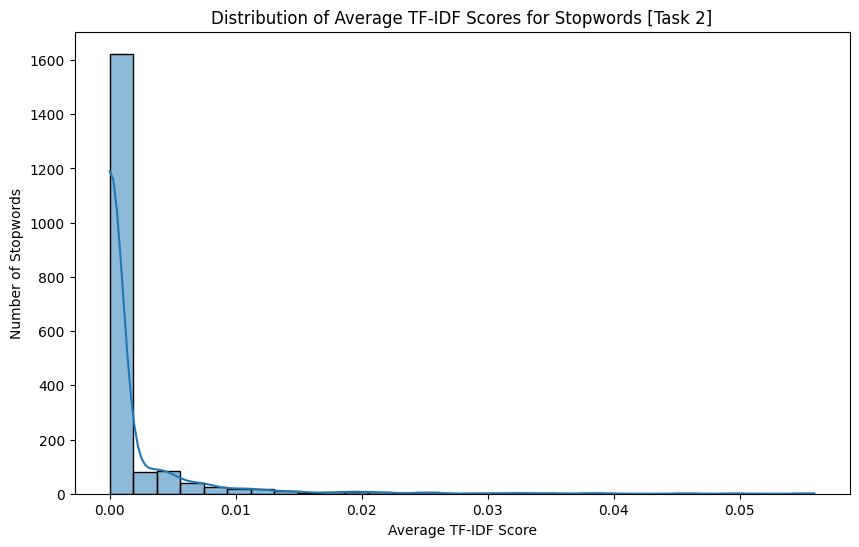

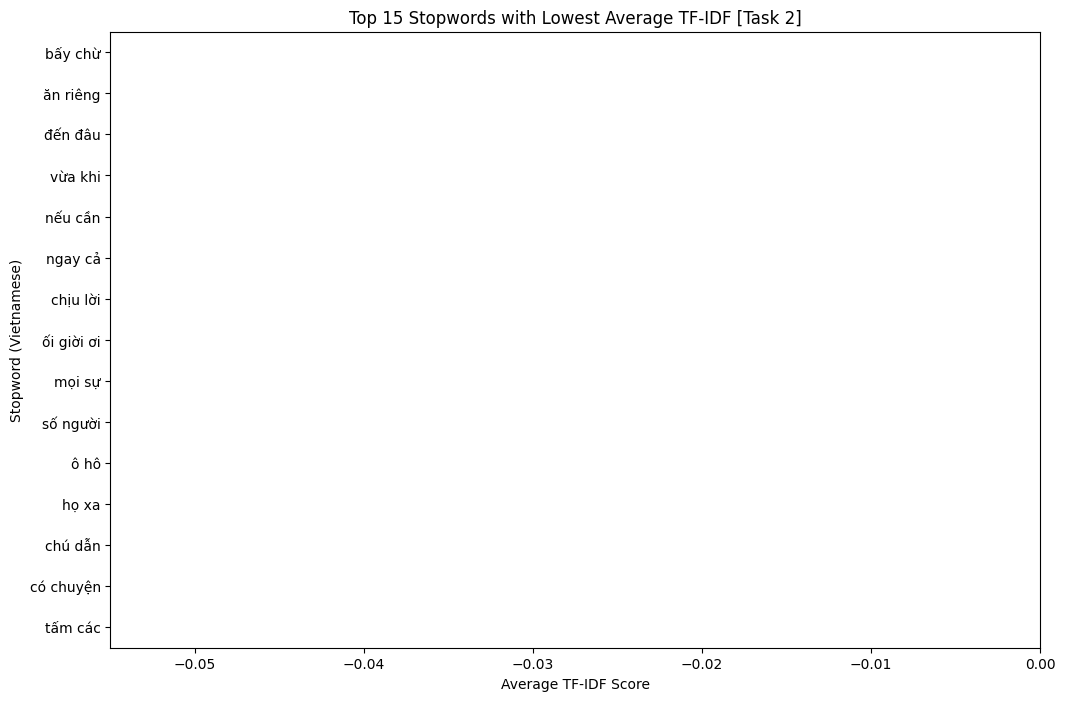

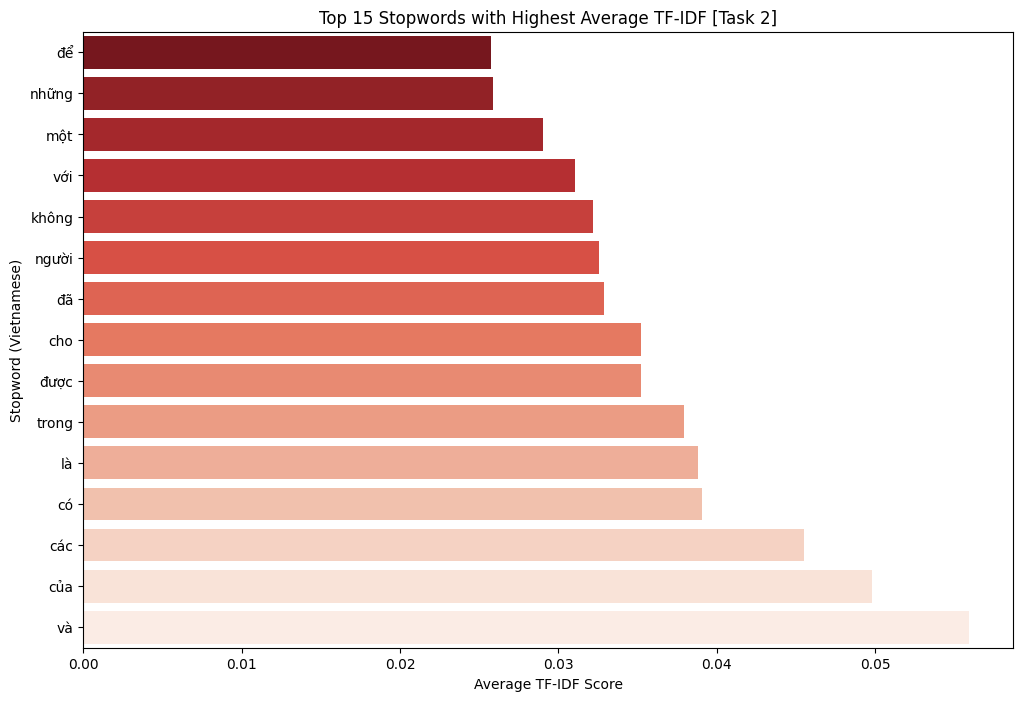

In [8]:
# Plots
plt.figure(figsize=(10, 6)) 
sns.histplot(tfidf_stats_df['Average TF-IDF'], bins=30, kde=True)
plt.title('Distribution of Average TF-IDF Scores for Stopwords [Task 2]')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Number of Stopwords')

plt.savefig('plot/task2_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average TF-IDF', y='Stopword', data=lowest_15_df, palette='Blues_r')
plt.title('Top 15 Stopwords with Lowest Average TF-IDF [Task 2]') 
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Stopword (Vietnamese)')
min_non_zero = tfidf_stats_df[tfidf_stats_df['Average TF-IDF'] > 0]['Average TF-IDF'].min()
if not pd.isna(min_non_zero) and lowest_15_df['Average TF-IDF'].max() < min_non_zero * 10:
     plt.xlim(right=min_non_zero * 10) 

plt.savefig('plot/task2_bottom15.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Average TF-IDF', y='Stopword', data=highest_15_df, palette='Reds_r')
plt.title('Top 15 Stopwords with Highest Average TF-IDF [Task 2]')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Stopword (Vietnamese)')

plt.savefig('plot/task2_top15.png', dpi=300, bbox_inches='tight')
plt.show()

### **Findings:**

1.  **Majority Behave as Expected:** A substantial portion of the stopwords (1280 out of 1942, approx. 66%) showed near-zero average TF-IDF scores (< 1e-5). This indicates that about two-thirds of the standard stopwords behave as expected in this news corpus – they appear widely or infrequently enough not to strongly differentiate between news topics like 'chinh-tri' (politics), 'the-thao' (sports), etc.
   
2.  **Least Discriminative:** Words like `rõ là` (obviously), `chớ như` (don't be like), `có cơ` (there is a chance), and `không có` (not available) are among those with effectively zero average TF-IDF. They offer virtually no signal for distinguishing between the news categories in this dataset.
   
3.  **Most Discriminative:** Common, high-frequency function words dominate the list of highest average TF-IDF scores, including `và` (and), `của` (of), `các` (the), `có` (have), `là` (is/to be), and `không` (not), with scores up to ~0.056. While essential grammatically, their relatively high scores suggest their usage frequency varies noticeably across the different news topics within our specific 2k-sample-per-category dataset. For example, conjunctions or negation might be more prevalent in 'politics' or 'law' articles than in 'sports'.


**Conclusion:** The TF-IDF analysis confirms that most standard Vietnamese stopwords function as expected (low discriminative power) within this news corpus. However, it also highlights that even the most common words can exhibit subtle variations in usage across different news topics.

# Question 3: Identify Top 100 TF-IDF Stopwords & Compare

In [20]:
# Load TF-IDF results
TASK2_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task2.pkl')
if os.path.exists(TASK2_TFIDF_PKL):
    print(f"Loading required Task 2 results from {TASK2_TFIDF_PKL}...")
    with open(TASK2_TFIDF_PKL, 'rb') as f:
        tfidf_stats_df = pickle.load(f)
    print("Task 2 results loaded.")
else:
    raise FileNotFoundError(f"Error: Task 2 results file not found at {TASK2_TFIDF_PKL}. Please run Task 2 code first.")

# Identify which columns represent TF-IDF scores across categories
tfidf_cols = [col for col in tfidf_stats_df.columns if col not in ['Stopword', 'Average TF-IDF']]

# --- Step 1: Compute how often each word has very low TF-IDF across categories ---
# You can tweak the threshold (e.g., 0.01 or 0.02) depending on your TF-IDF scale
LOW_TFIDF_THRESHOLD = 0.01

tfidf_stats_df['Low_Score_Count'] = (tfidf_stats_df[tfidf_cols] < LOW_TFIDF_THRESHOLD).sum(axis=1)
tfidf_stats_df['Low_Score_Ratio'] = tfidf_stats_df['Low_Score_Count'] / len(tfidf_cols)

# --- Step 2: Sort words ---
# Sort primarily by how often they have low TF-IDF, then by lowest average TF-IDF
tfidf_stats_df_sorted_task3 = tfidf_stats_df.sort_values(
    ['Low_Score_Ratio', 'Average TF-IDF'],
    ascending=[False, True]
)

# --- Step 3: Select top 100 most suitable stopwords ---
top_100_tfidf_stopwords_list = tfidf_stats_df_sorted_task3.head(100)['Stopword'].tolist()
top_100_tfidf_stopwords_set = set(top_100_tfidf_stopwords_list)

print(f"Identified the 100 most suitable stopwords based on consistent low TF-IDF across categories.")

# --- Step 4: Compare with Vietnamese stopword list ---
common_stopwords_task3 = top_100_tfidf_stopwords_set.intersection(vietnamese_stopwords_set)

# --- Step 5: Compute overlap percentage ---
overlap_percentage_task3 = (
    (len(common_stopwords_task3) / len(top_100_tfidf_stopwords_set)) * 100
    if len(top_100_tfidf_stopwords_set) > 0 else 0
)

# --- Step 6: Display results ---
print(f"\nOverlap: Top 100 TF-IDF Stopwords vs Vietnamese Stopword List")
print(f"Vietnamese list size: {len(vietnamese_stopwords_set)}")
print(f"Top 100 TF-IDF list size: {len(top_100_tfidf_stopwords_set)}")
print(f"Number of common words: {len(common_stopwords_task3)}")
print(f"Overlap Percentage: {overlap_percentage_task3:.2f}%")




Loading required Task 2 results from pkl_folder\task2.pkl...
Task 2 results loaded.
Identified the 100 most suitable stopwords based on consistent low TF-IDF across categories.

Overlap: Top 100 TF-IDF Stopwords vs Vietnamese Stopword List
Vietnamese list size: 1942
Top 100 TF-IDF list size: 100
Number of common words: 100
Overlap Percentage: 100.00%


In [21]:

first_20_stopwords_task3 = top_100_tfidf_stopwords_list[:20]

print("\nTranslating the first 20 words from the 'most suitable' TF-IDF list...")
# Assumes translate_words function exists from Task 2 adjustments
translations_task3 = translate_words(first_20_stopwords_task3)

# Create a DataFrame for display
translation_df_task3 = pd.DataFrame({
    'Rank': range(1, 21),
    'Stopword (VI)': first_20_stopwords_task3,
    'Translation (EN)': translations_task3
})

print("\nFirst 20 words in the 'most suitable' TF-IDF list (with Translation):")
print(translation_df_task3.to_markdown(index=False))




Translating the first 20 words from the 'most suitable' TF-IDF list...

First 20 words in the 'most suitable' TF-IDF list (with Translation):
|   Rank | Stopword (VI)   | Translation (EN)   |
|-------:|:----------------|:-------------------|
|      1 | buổi sớm        | Error              |
|      2 | ngồi sau        | sit back           |
|      3 | à ơi            | ah oh              |
|      4 | đúng tuổi       | right age          |
|      5 | tên cái         | female name        |
|      6 | ít nữa          | less               |
|      7 | lại còn         | also               |
|      8 | khó nghĩ        | ticklish           |
|      9 | cần số          | gear lever         |
|     10 | trong mình      | inside me          |
|     11 | bằng ấy         | by that            |
|     12 | bỏ lại          | leave              |
|     13 | mọi thứ         | everything         |
|     14 | đâu có          | no                 |
|     15 | trực tiếp làm   | do it directly     |
|     1

# Question 4: Identify stopwords

In [11]:

# Define filename for caching
TASK4_ZERO_TFIDF_PKL = os.path.join(PKL_FOLDER, 'task4.pkl')

# Check if cached results exist
if os.path.exists(TASK4_ZERO_TFIDF_PKL):
    print(f"Loading cached Task 4 results from {TASK4_ZERO_TFIDF_PKL}...")
    with open(TASK4_ZERO_TFIDF_PKL, 'rb') as f:
        zero_tfidf_stopwords_list = pickle.load(f)
    print("Task 4 results loaded.")

else:
    print(f"Cache not found for Task 4. Running analysis...")

    if 'vietnamese_stopwords_set' not in locals():
         vietnamese_stopwords_set = set(stopword_df['word'].tolist())

    # Prepare data structures
    categories = vn_df['label'].unique()
    num_categories = len(categories)

    # 50% threshold (>= half the categories)
    threshold_categories = np.ceil(num_categories / 2.0) 
    # Store True/False for zero score: {stopword: [is_zero_cat0, is_zero_cat1,...]}
    stopword_is_zero_scores = {word: [] for word in vietnamese_stopwords_set}

    # Define tokenizer
    def vn_tokenizer(text):
        # Lemmatization skipped
        return word_tokenize(str(text).lower()) 

    # Calculate TF-IDF per category and check for zero score
    print("Calculating TF-IDF per category to check for zero scores...")
    for category in tqdm(categories, desc="Processing Categories for Task 4"):
        # Use 'content' for news dataset
        category_texts = vn_df[vn_df['label'] == category]['content'].tolist() 
        tfidf_vectorizer = TfidfVectorizer(tokenizer=vn_tokenizer, stop_words=None) 

        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(category_texts)
            feature_names = tfidf_vectorizer.get_feature_names_out()
            vocab_index = {word: idx for idx, word in enumerate(feature_names)}

            for stopword in vietnamese_stopwords_set:
                if stopword in vocab_index:
                    avg_score = np.mean(tfidf_matrix[:, vocab_index[stopword]].toarray()) 
                    # Use a small tolerance for zero check
                    is_zero = avg_score < 1e-9 
                    stopword_is_zero_scores[stopword].append(is_zero)
                else:
                    # Treat as zero if not present in category vocab
                    stopword_is_zero_scores[stopword].append(True) 

        except ValueError as e: # Handle empty categories
            print(f"Skipping category {category} due to error: {e}")
            for stopword in vietnamese_stopwords_set:
                 # Treat as zero if category fails
                 stopword_is_zero_scores[stopword].append(True) 

    # Identify stopwords meeting the zero-score threshold
    print(f"Identifying stopwords with TF-IDF score zero in >= {threshold_categories:.0f} categories...")
    zero_tfidf_stopwords_list = []
    for stopword, zero_flags in stopword_is_zero_scores.items():
        # Count True flags (zero scores)
        zero_count = sum(zero_flags) 
        if zero_count >= threshold_categories:
            zero_tfidf_stopwords_list.append(stopword)

    # Save the identified list
    print(f"Analysis complete. Saving results to {TASK4_ZERO_TFIDF_PKL}...")
    with open(TASK4_ZERO_TFIDF_PKL, 'wb') as f:
        pickle.dump(zero_tfidf_stopwords_list, f) 
    print("Task 4 results saved.")


# Compare the identified list with the default NLTK list
zero_tfidf_stopwords_set = set(zero_tfidf_stopwords_list)
# This intersection will contain exactly the words in zero_tfidf_stopwords_set
common_stopwords_task4 = zero_tfidf_stopwords_set.intersection(vietnamese_stopwords_set) 

# Display results
print(f"\nStopwords with TF-IDF Zero in >= {threshold_categories:.0f} (50%) Categories")
print(f"Original NLTK list size: {len(vietnamese_stopwords_set)}")
print(f"Number of stopwords meeting zero TF-IDF criteria: {len(zero_tfidf_stopwords_set)}")



Cache not found for Task 4. Running analysis...
Calculating TF-IDF per category to check for zero scores...


Processing Categories for Task 4:   0%|          | 0/8 [00:00<?, ?it/s]

Identifying stopwords with TF-IDF score zero in >= 4 categories...
Analysis complete. Saving results to pkl_folder\task4.pkl...
Task 4 results saved.

Stopwords with TF-IDF Zero in >= 4 (50%) Categories
Original NLTK list size: 1942
Number of stopwords meeting zero TF-IDF criteria: 1364


In [16]:
zero_tfidf_list_size = len(zero_tfidf_stopwords_set)
original_list_size = len(vietnamese_stopwords_set)
proportion = zero_tfidf_list_size / original_list_size
percentage = proportion * 100

print(f"The extent of overlapping (Stopwords with TF-IDF ≈ 0 in >= 50% of categories vs. Original List) is \
      \n{zero_tfidf_list_size} / {original_list_size}, which equals {percentage:.2f}%.")

The extent of overlapping (Stopwords with TF-IDF ≈ 0 in >= 50% of categories vs. Original List) is       
1364 / 1942, which equals 70.24%.


In [ ]:



# Show some examples from the list with translation
if zero_tfidf_stopwords_list:
    print(f"\nFirst 20 examples from the 'zero TF-IDF' list:")
    # Get the first 20 words after sorting
    first_20_zero_tfidf = sorted(zero_tfidf_stopwords_list)[:20]

    if translator:
        print("Translating the first 20 words...")
        translations_task4 = translate_words(first_20_zero_tfidf)

        # Create a DataFrame for display
        translation_df_task4 = pd.DataFrame({
            'Stopword (VI)': first_20_zero_tfidf,
            'Translation (EN)': translations_task4
        })
        print(translation_df_task4.to_markdown(index=False))

    else:
        print("(Translator unavailable)")
        print(first_20_zero_tfidf)

else:
    print("\nNo stopwords met the zero TF-IDF criteria.")


First 20 examples from the 'zero TF-IDF' list:
Translating the first 20 words...
| Stopword (VI)   | Translation (EN)   |
|:----------------|:-------------------|
| a ha            | aha                |
| a lô            | hello              |
| ai đó           | someone            |
| alô             | Hello              |
| amen            | amen               |
| anh ấy          | he                 |
| ba ba           | ba ba              |
| ba bản          | three copies       |
| ba cùng         | three together     |
| ba họ           | three families     |
| ba ngày         | three days         |
| ba ngôi         | Trinity            |
| ba tăng         | three monks        |
| bao nả          | intense            |
| bay biến        | fly away           |
| biết chắc       | know for sure      |
| biết chừng nào  | know how much      |
| biết mình       | know me            |
| biết mấy        | who knows?         |
| biết thế        | know that          |
